### SHRED applied to SST dataset

Link for opening in Colab: https://colab.research.google.com/drive/1Q5Zttwf_mHjJQflo87o1dDHPPzWgqsNm?usp=sharing

Link for accessing SST data: https://drive.google.com/file/d/1IuXO1U4Q0SOU36P12384U2VuOZSK3Z8a/view?usp=sharing

If you are running this notebook on your computer, download the data. If you are running the notebook on Colab, move the data to your google drive and mount the drive.

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    '''Takes input sequence of sensor measurements with shape (batch size, lags, num_sensors)
    and corresponding measurments of high-dimensional state, return Torch dataset'''
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return self.len

In [ ]:
class SHRED(torch.nn.Module):
    '''SHRED model accepts input size (number of sensors), output size (dimension of high-dimensional spatio-temporal state, hidden_size, number of LSTM layers,
    size of fully-connected layers, and dropout parameter'''
    def __init__(self, input_size, output_size, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.0):
        super(SHRED,self).__init__()

        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                 num_layers=hidden_layers, batch_first=True)
        
        self.linear1 = torch.nn.Linear(hidden_size, l1)
        self.linear2 = torch.nn.Linear(l1, l2)
        self.linear3 = torch.nn.Linear(l2, output_size)

        self.dropout = torch.nn.Dropout(dropout)

        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

        

    def forward(self, x):
        
        h_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        c_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        if next(self.parameters()).is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out[-1].view(-1, self.hidden_size)

        output = self.linear1(h_out)
        output = self.dropout(output)
        output = torch.nn.functional.relu(output)

        output = self.linear2(output)
        output = self.dropout(output)
        output = torch.nn.functional.relu(output)
    
        output = self.linear3(output)

        return output

In [ ]:
def fit(model, train_dataset, valid_dataset, batch_size=64, num_epochs=4000, lr=1e-3, verbose=False, patience=5):
    '''Function for training SHRED models'''
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    val_error_list = []
    patience_counter = 0
    best_params = model.state_dict()
    for epoch in range(1, num_epochs + 1):
        
        for k, data in enumerate(train_loader):
            model.train()
            outputs = model(data[0])
            optimizer.zero_grad()
            loss = criterion(outputs, data[1])
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0 or epoch == 1:
            model.eval()
            with torch.no_grad():
                val_outputs = model(valid_dataset.X)
                val_error = torch.linalg.norm(val_outputs - valid_dataset.Y)
                val_error = val_error / torch.linalg.norm(valid_dataset.Y)
                val_error_list.append(val_error)

            if verbose == True:
                print('Training epoch ' + str(epoch))
                print('Error ' + str(val_error_list[-1]))

            if val_error == torch.min(torch.tensor(val_error_list)):
                patience_counter = 0
                best_params = model.state_dict()
            else:
                patience_counter += 1


            if patience_counter == patience:
                model.load_state_dict(best_params)
                return torch.tensor(val_error_list).cpu()

    model.load_state_dict(best_params)
    return torch.tensor(val_error_list).detach().cpu().numpy()

Load the data.

In [ ]:
load_X = loadmat('/content/drive/MyDrive/SST_data.mat')['Z'].T
mean_X = np.mean(load_X, axis=0)
sst_locs = np.where(mean_X != 0)[0]
load_X = load_X[:, sst_locs]

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [ ]:
num_sensors = 3 
lags = 52
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [ ]:
train_indices = np.arange(1000)
valid_indices = np.arange(1000,1100)
test_indices = np.arange(1100,1200)

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [ ]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements, since we're just reconstructing
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [ ]:
shred = SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=2)

Training epoch 1
Error tensor(0.4885)
Training epoch 20
Error tensor(0.2540)
Training epoch 40
Error tensor(0.2441)


KeyboardInterrupt: ignored

Finally, we generate reconstructions from the test set and print error relative to the ground truth.

In [ ]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.041166656


Plot Reconstructions

In [ ]:
load_X_temp = loadmat('/content/drive/MyDrive/SST_data.mat')['Z'].T
mean_X_temp = np.mean(load_X_temp, axis=0)
sst_locs = np.where(mean_X_temp != 0)[0]
to_plot_recon = np.zeros((64800))
to_plot_recon[sst_locs] = test_recons[0]

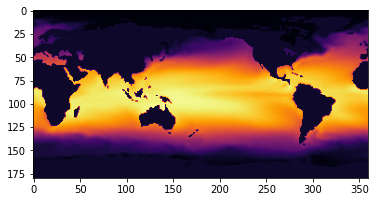

In [ ]:
plt.imshow(to_plot_recon.reshape(180,360),cmap='inferno')
plt.show()

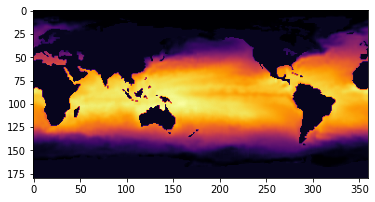

In [ ]:
to_plot_truth = np.zeros(64800)
to_plot_truth[sst_locs] = test_ground_truth[0]
plt.imshow(to_plot_truth.reshape(180,360), cmap='inferno')
plt.show()